# Machine Learning para la Detección de Tuberculosis

El objetivo de este notebook es crear un modelo de clasificación de personas con tuberculosis o sin ella. Para ello se usan radiografías pulmonares pertenecientes al China_set y Montgomery_set.

In [108]:
import os
import cv2
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [ ]:
#!pip3 install imutils
#!pip3 install -q -U watermark

In [2]:
# Versiones de los paquetes usados en este notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Enero 2022" --iversions
!python --version

Author: César S. Hooper/ Enero 2022

numpy     : 1.18.1
pandas    : 1.0.1
cv2       : 4.2.0
matplotlib: 3.1.3
sklearn   : 0.22.1
seaborn   : 0.10.0

Python 3.7.6


In [3]:
path1 = '/media/datasets/IAMED/Cap02//ChinaSet_AllFiles/CXR_png'
path2 = '/media/datasets/IAMED/Cap02/MontgomerySet/CXR_png'
path = '/home/csanchez'

In [8]:
rutas = [path1, path2]

Estas son algunas de las imágenes

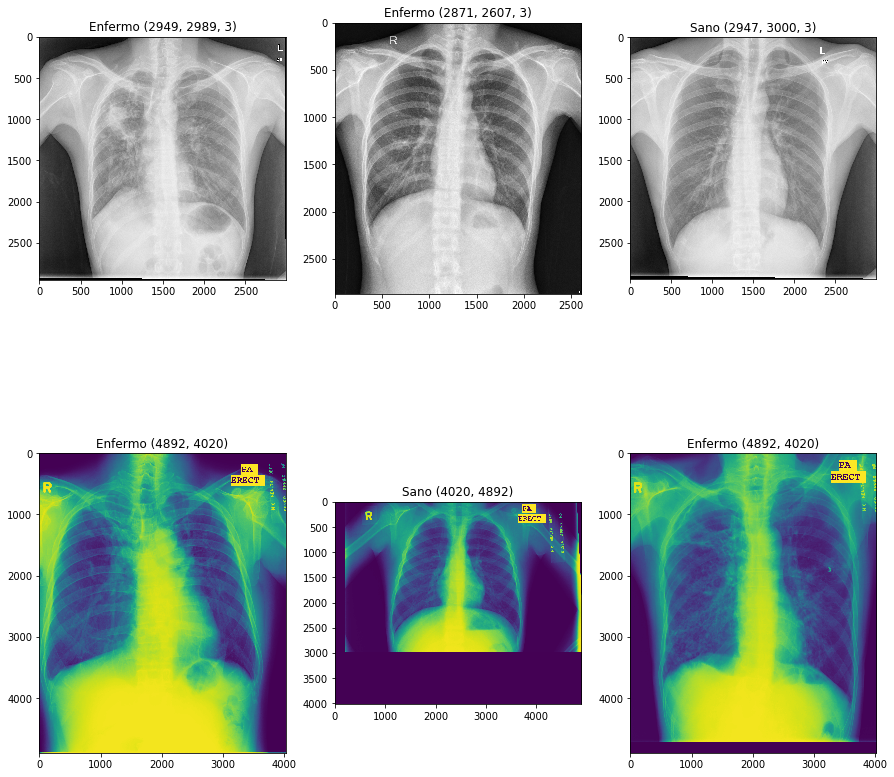

In [7]:
k = 1
plt.figure(figsize=(15,15))
for ruta in rutas:
    for imagen in np.random.choice(os.listdir(ruta), 3):
        img = plt.imread(ruta + '/' + imagen)
        plt.subplot(2,3,k)
        plt.imshow(img)
        k += 1
        if imagen[-5] == '0': plt.title('Sano ' + str(img.shape))
        else: plt.title('Enfermo ' + str(img.shape))

Vamos a crear algunas funciones que nos serán de utilidad.

### Algunas funciones útiles

In [16]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.YlOrRd):
    """Función para graficar las matriz de confusión"""

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # mostramos en pantalla matriz confusion (cm)
    print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

In [9]:
def elimina_bordes(imagen_gris):
    
    """Elimina los bordes negros de las imágenes"""
    
    yoyo = cv2.resize(imagen_gris, (500, 500)) 
    k = 0
    while True:
        _ , vcant = np.unique(yoyo[:, k], return_counts=True)
        filas, _ = yoyo.shape
        if vcant[0]==filas:
            yoyo = np.delete(yoyo, k, axis=1)
        else:
            k += 1

        if k == yoyo.shape[1]: break  

    q = 0
    while True:
        _, hcant = np.unique(yoyo[q, :], return_counts=True)
        _, columnas = yoyo.shape
        if hcant[0]==columnas:
            yoyo = np.delete(yoyo, q, axis=0)
        else:
            q += 1

        if q == yoyo.shape[0]: break
    return yoyo

In [11]:
def perfiles(umbral):
    
    """retorna perfil_horizontal, perfil_vertical ---
    La imagen debe llegar redimensionada y umbralizada"""
    
    vperfil = dict()
    hperfil = dict()
    for k in range(umbral.shape[0]):
        
        # perfil vertical
        vunique, vcounts = np.unique(thres[k, :], return_counts=True)
        
        if 255 in (vunique): vperfil[k] = vcounts[vunique==255][0]
        else: vperfil[k] = 0
    for k in range(umbral.shape[1]):
        
                 
        # perfil horizontal
        hunique, hcounts = np.unique(thres[:, k], return_counts=True)
        if 255 in (hunique): hperfil[k] = hcounts[hunique==255][0]
        else: hperfil[k] = 0
        
    return hperfil, vperfil

In [12]:
def filtro(arreglo, valor_min, valor_max):
    
    """Función para determinar si arreglo está contenido en Rango---
    Retorna lista con valores de arreglo contenidos en rango"""
    
    rango = np.arange(valor_min, valor_max)
    filtrados = []
    
    if len(arreglo) == 1: filtrados.append(max(arreglo))
    else:
        
        for k in arreglo:
            if k in rango: filtrados.append(k)
                
    return max(filtrados)

In [13]:
def coordenadas(vert, horz): 
    
    """Funición que retorna las coordenadas de los vértices superior izquierdo
    e inferior derecho del rectángulo de segmentación"""
    
    vertical = list(vert.values())
    horizontal = list(horz.values())
    
    # vertical y1, y2
    vmax1 = max(vertical[10:100]) # [10:100]
    vmax2 = max(vertical[200:250])
    y1 = filtro(list(np.where(vertical==vmax1)[0]), 10, 100)
    y2 = filtro(list(np.where(vertical==vmax2)[0]), 200, 250)
    
    # horizontal x1, x2
    hmax1 = max(horizontal[10:100])
    hmax2 = max(horizontal[200:280])
    
    x1 = filtro(list(np.where(horizontal==hmax1)[0]), 10, 100)
    x2 = filtro(list(np.where(horizontal==hmax2)[0]), 200, 280)
    
    
    return x1, x2, y1, y2

In [14]:
def imagen_augmented(imagen, angulo, random_state):
    """Función que crea imágenes sintéticas a partir de las imágenes originales"""
    
    height, width = imagen.shape
    center = (width/2, height/2)
    angle = np.random.randint(-angulo, angulo, 1)[0]
    
    i = np.random.randint(0, random_state)
    
    if i%2 == 0: img_aug = cv2.flip(imagen, 1)
    else:
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
        img_aug = cv2.warpAffine(src=imagen, M=rotate_matrix, dsize=(width, height)) 
    
    return img_aug

## Pre-procesamiento de las imágenes.
Las imágenes están en bruto: en diferentes dimensiones, con 1 o 3 canales, algunas con bordes negros, etc.
Por  tanto en una primera etapa es necesario procesarlas antes de usarlar para entrenar un modeo de clasificación.

Una vez que las imágenes están un mismo formato se procede a segmentarlas.


**Segmentación de los pulmones**

A continuación se muestran algunos pulmones segmentados. El método de segmentación de los pulmones se describirá en un próximo notebook, con más detalle. Basta señalar aquí que en el proceso cada imagen se redujo a un canal, se umbralizó y luego se estudió los perfiles de intensidad para determinar de manera automática los límites de cada segmento. 

El proceso total está descrito en la siguiente rutina. Los gráficos corresponden a los perfiles de intensidad vertical y horizontal, respectivamente. 

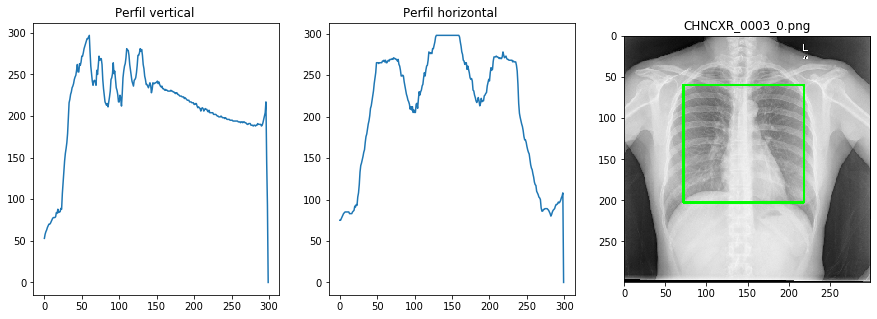

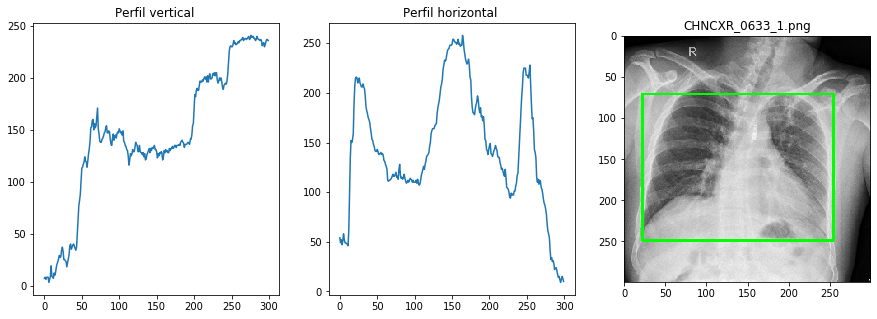

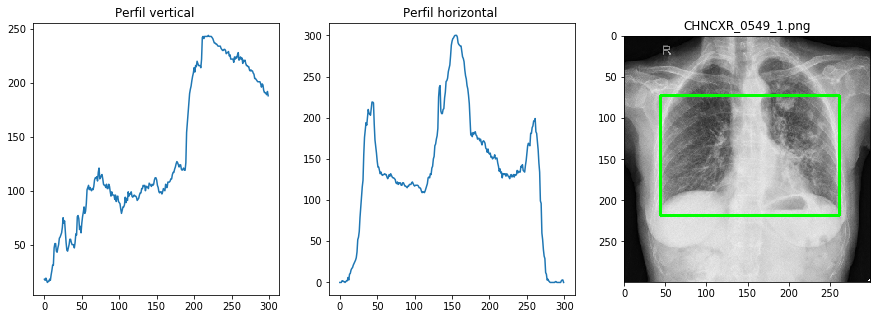

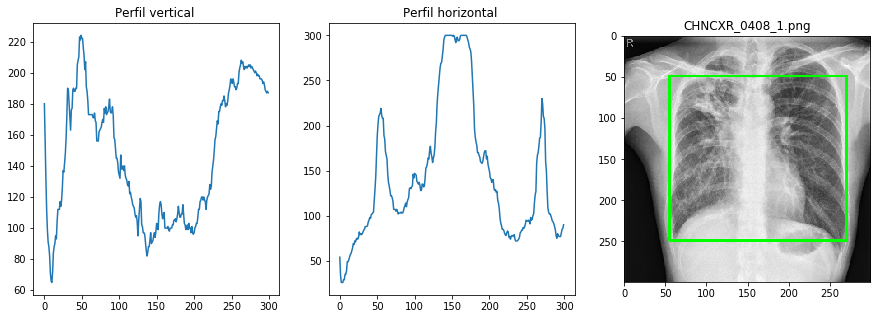

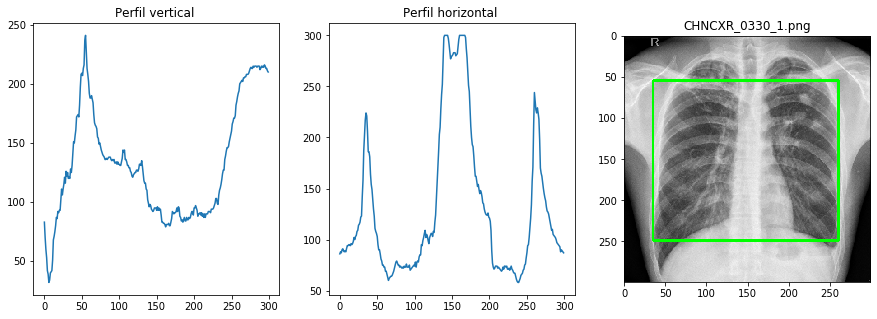

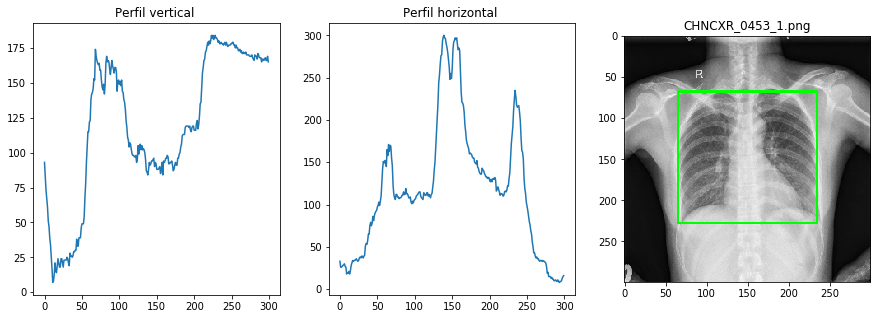

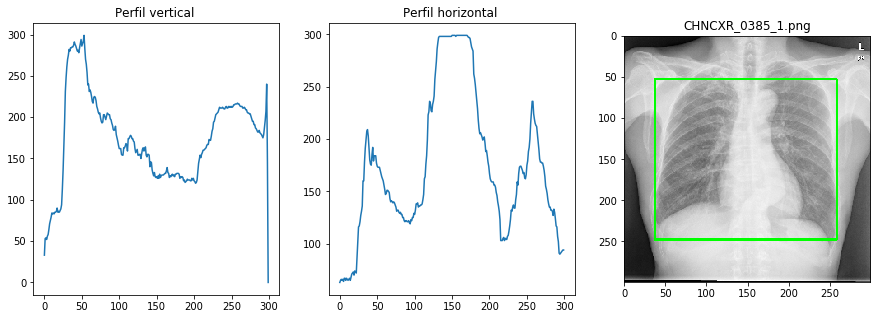

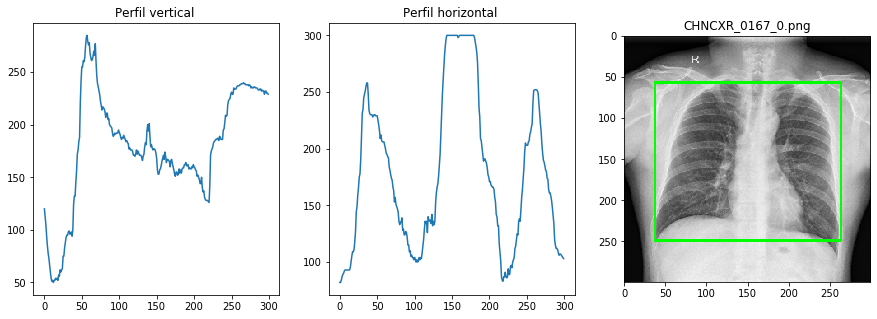

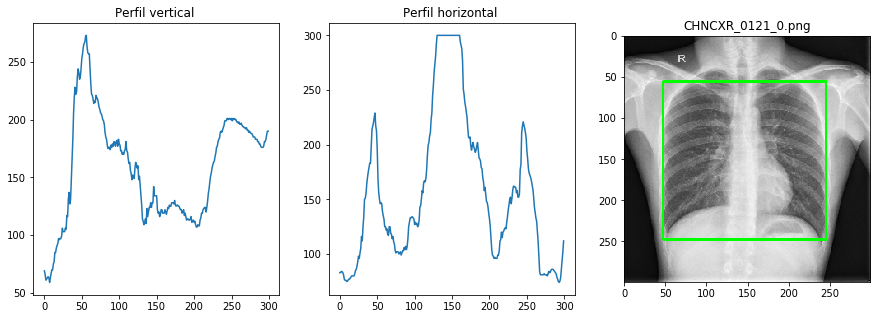

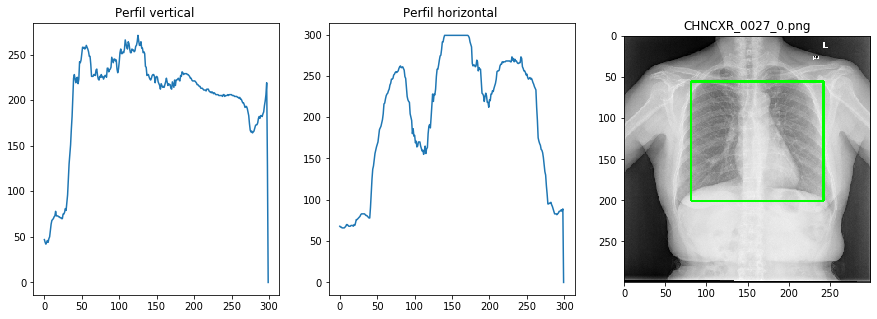

In [18]:
# Imagenes chinaset
for nombre in np.random.choice(os.listdir(path1), 10):
    #if nombre
    img = cv2.imread(path1 + '/' + nombre)
    # umbralización
    img = cv2.resize(img, (300,300)) 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    auxframe = img.copy()

    if nombre[-5] == '0':
        _, thres = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
    else:
        _, thres = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

    # crea los perfiles
    horz, vert= perfiles(thres)

    # coordenadas del  centro:  
    x1, x2, y1, y2 = coordenadas(vert, horz)

    # rectangulo
    cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),2)
    imagen = auxframe[y1:y2, x1:x2]        

    # grafica perfiles

    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(list(vert.keys()), list(vert.values()))
    plt.title('Perfil vertical ')
    plt.subplot(1, 3, 2)
    plt.plot(list(horz.keys()), list(horz.values()))
    plt.title('Perfil horizontal ')
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.title(nombre)
    plt.show()

A continuación, el código para guardar las imágenes segmentadas, en directorios Sanos y enfermos, respectivamente.

#### Guarda imágenes segmentadas ChinaSet

In [20]:
# Imágenes chinaset-files
k = 0
  
for nombre in os.listdir(path1):
    if nombre[-3:] == 'png':
        img = cv2.imread(path1 + '/' + nombre)
        # umbralización
        img = cv2.resize(img, (300,300), interpolation=cv2.INTER_AREA)
        gris = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        

        auxframe = img.copy()

        if nombre[-5] == '0':
            _, thres = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
        else:
            _, thres = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)

        # crea los perfiles
        horz, vert= perfiles(thres)

        # coordenadas del  centro:  
        x1, x2, y1, y2 = coordenadas(vert, horz)

        # rectangulo
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),2)
        imagen = auxframe[y1:y2, x1:x2]

        # crea directorio para imágenes segmentadas
        imag_segmentadas = path + '/imag_segmentadas'
        if not os.path.exists(imag_segmentadas): os.mkdir(imag_segmentadas)

        # crea subdirectorios sano, enfermo para imagenes segmentadas respectivas
        sanos = imag_segmentadas + '/sanos'
        if not os.path.exists(sanos): os.mkdir(sanos)
        enfermos = imag_segmentadas + '/enfermos'
        if not os.path.exists(enfermos): os.mkdir(enfermos)

        # guarda imagenes segmentadas en sus respectivos directorios
        if nombre[-5] == '0': 
            cv2.imwrite(sanos + '/chinaset' + str(k) + '_' + str(0) + '.jpg', imagen)
        elif nombre[-5] == '1': 
            cv2.imwrite(enfermos + '/chinaset' + str(k) + '_' + str(1) + '.jpg', imagen)

    k += 1
k

663

In [21]:
imag_segmentadas = path + '/imag_segmentadas'
sanos = imag_segmentadas + '/sanos'
enfermos = imag_segmentadas + '/enfermos'

#### Guarda Imágenes segmentadas Montgomery_Set

In [22]:
# Guarda Imágenes Montgomery_set files
n = 663
for nombre in os.listdir(path2):
    #print(n, nombre)
    if nombre[-3:] == 'png':
        img0 = cv2.imread(path2 + '/' + nombre)
        gray = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
        img_filtrada = elimina_bordes(gray)
        
        # esta es la imagen fitrada de (500, 500)
        img = cv2.resize(img_filtrada, (300,300), interpolation=cv2.INTER_AREA)

        auxframe = img.copy()
        
        # umbralización
        if nombre[-5] == '0':
            _, thres = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
        else:
            _, thres = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)

        # crea los perfiles
        horz, vert= perfiles(thres)

        # coordenadas del  centro:  
        x1, x2, y1, y2 = coordenadas(vert, horz)

        # rectangulo
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0),2)
        imagen = auxframe[y1:y2, x1:x2]
        
        # guarda imagenes segmentadas en sus respectivos directorios
        if nombre[-5] == '0': 
            cv2.imwrite(sanos + '/montgomeryset' + str(n) + '_' + str(0) + '.jpg', imagen)
        elif nombre[-5] == '1': 
            cv2.imwrite(enfermos + '/montgomeryset' + str(n) + '_' + str(1) + '.jpg', imagen)
        
    n += 1

A continuación se exponen algunas de las imágenes segmentadas

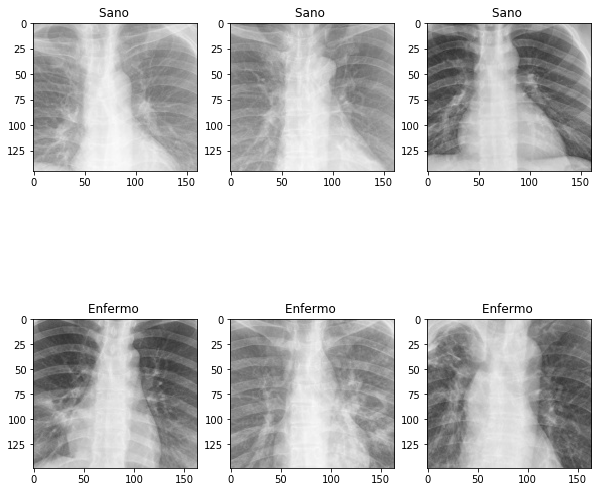

In [30]:
# verificando las imágenes segmentadas guardadas
camino = imag_segmentadas
caminos = [sanos, enfermos]
k = 1
plt.figure(figsize=(10,10))
for ruta in caminos:
    #calle = camino + '/' + ruta
    for name in np.random.choice(os.listdir(ruta),3):
        img = plt.imread(ruta + '/' + name)
        plt.subplot(2,3,k)
        plt.imshow(img)
        k += 1
        if name[-5] == '0': plt.title('Sano ')
        elif name[-5]=='1': plt.title('Enfermo ')

## Imágenes sintéticas
Se crean imágenes sintéticas a partir de las imágenes segmentadas, para complementar, usando opencv.


In [31]:
# crea los directorios para guardar imágenes sintéticas
# crea imágenes sintéticas y las guarda en directorios
# aug_sanos y aug_enfermos
caminos = [sanos, enfermos]

aug_sanos = imag_segmentadas + '/aug_sanos'
if not os.path.exists(aug_sanos): os.mkdir(aug_sanos)
aug_enfermos = imag_segmentadas + '/aug_enfermos'
if not os.path.exists(aug_enfermos): os.mkdir(aug_enfermos)

k = 0
for cam in caminos:
    
    for imagen in np.random.choice(os.listdir(cam), 120):
        
        im = cv2.imread(cam + '/' + imagen, 0)
        img_aug = imagen_augmented(im, 10, 100)
        if imagen[-5] == '0': 
            cv2.imwrite(aug_sanos + '/aug_img' + str(k) + '_' + str(0) + '.jpg', img_aug)
        elif imagen[-5] == '1': 
            cv2.imwrite(aug_enfermos + '/aug_img' + str(k) + '_' + str(1) + '.jpg', img_aug)
            
        k += 1


In [32]:
directorios = [sanos, aug_sanos, enfermos, aug_enfermos]

total_sanos = len(os.listdir(sanos)) + len(os.listdir(aug_sanos))
total_enfermos = len(os.listdir(enfermos)) + len(os.listdir(aug_enfermos))
total = total_sanos + total_enfermos
print('Total Sanos %.0f'%total_sanos)
print('Total Enfermos %.0f'%total_enfermos)
print('Total Imágenes %.0f'%total)

Total Sanos 526
Total Enfermos 514
Total Imágenes 1040


## Crea dataframes 

In [33]:
k = 1
lista = []
directorios = [sanos, aug_sanos, enfermos, aug_enfermos]
for directorio in directorios:
    
    #ruta = imag_segmentadas + directorio
    
    for foto in os.listdir(directorio):
        img = cv2.imread(directorio + '/' + foto, 0)
        img = cv2.resize(img, (100,100), interpolation=cv2.INTER_CUBIC)
        #gris = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        lista.append(img)
        
# tranformar la lista en array
x = np.array(lista)

# las matrices dentro del array en arrays de (1, 10000)
x = x.reshape(-1,10000) # este es un array de (4004, 10000)
xx = x[12::]
xx.shape

(1028, 10000)

In [36]:
# creamos diccionario y  luego dataframe
# target sano: 0, enfermo: 1
s = {}
for columna in range(x.shape[1]):
    s['p'+str(columna)] = list(xx[:,columna])

dataframe = pd.DataFrame(s)    

# crear labels
k = np.arange(2)
labels = np.repeat(k, dataframe.shape[0]/2)

dataframe['target'] = labels

# randomizamos las filas del dataframe
dataframe_random = dataframe.sample(frac=1).reset_index(drop=True)

# separamos los datos de imágenes de los labels
y = dataframe_random['target']
X = dataframe_random.drop(['target'], axis=1)

In [37]:
dataframe_random.head(10)

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p9991,p9992,p9993,p9994,p9995,p9996,p9997,p9998,p9999,target
0,209,213,215,216,214,210,207,208,211,200,...,192,189,186,183,175,150,135,143,141,1
1,139,134,133,136,121,119,115,118,120,122,...,215,218,221,220,224,221,215,215,216,0
2,197,199,201,206,202,209,213,212,218,207,...,165,164,164,162,166,175,212,219,218,1
3,186,159,155,154,155,158,161,163,171,190,...,231,231,233,231,231,230,231,230,227,1
4,194,196,206,204,192,185,163,154,153,138,...,119,127,126,133,135,141,153,145,141,1
5,182,183,190,202,191,178,178,165,158,159,...,133,142,180,200,191,181,161,146,132,0
6,206,206,207,208,210,210,213,214,216,214,...,175,173,177,177,180,166,175,205,202,1
7,172,172,172,172,171,173,176,178,181,184,...,139,143,142,141,135,136,134,139,144,0
8,0,0,1,0,0,204,233,235,227,226,...,163,156,157,154,0,0,0,0,0,0
9,84,87,87,89,89,89,95,99,109,114,...,131,143,142,150,148,148,168,220,217,0


In [38]:
_, cant = np.unique(dataframe_random['target'], return_counts=True)
print('Hay ' + str(cant) + ' de sanos y enfermos, respectivamente')

Hay [514 514] de sanos y enfermos, respectivamente


### Creación del modelo

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [113]:
# Vamos a escalar los datos. 
# Crea el objeto y fitea
scaler = StandardScaler()
scaler.fit(X_train)

# normaliza los datos
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

### Random Forest Classifier

In [115]:
# Random Forest
# crea Classifier
rfc=RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_split=10)

# Entrena modelo y lo aplica para predecir
rfc.fit(X_train_tf,y_train)

y_train_pred_rf = rfc.predict(X_train_tf)
y_pred_rf=rfc.predict(X_test_tf)

print("Accuracy test: %.5f"%metrics.accuracy_score(y_test, y_pred_rf), '\n'
     'Accuracy train: %.5f'%metrics.accuracy_score(y_train, y_train_pred_rf))

Accuracy test: 0.81230 
Accuracy train: 1.00000


**Matriz confusión Test**

Matriz de Confusão Sem Normalização
[[129  21]
 [ 37 122]]


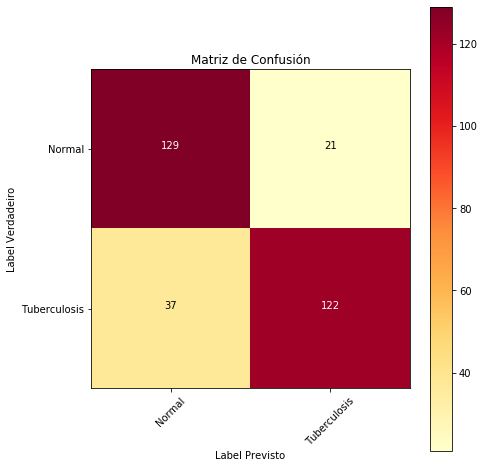

In [116]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf_rf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [117]:
report = classification_report(y_test, y_pred_rf , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.78      0.86      0.82       150
Tuberculosis       0.85      0.77      0.81       159

    accuracy                           0.81       309
   macro avg       0.82      0.81      0.81       309
weighted avg       0.82      0.81      0.81       309



**Matriz confusión Train**

Matriz de Confusão Sem Normalização
[[364   0]
 [  0 355]]


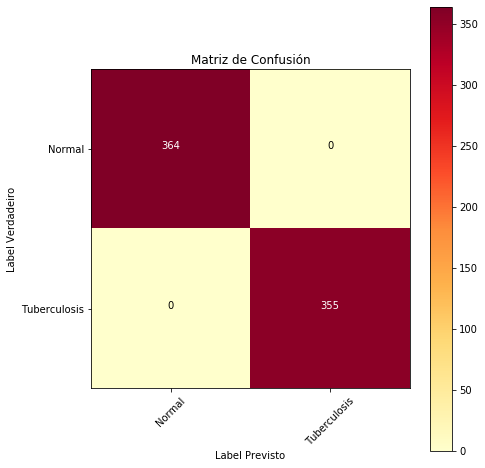

In [118]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf_rf = confusion_matrix(y_train, y_train_pred_rf)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf_rf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [119]:
report = classification_report(y_train, y_train_pred_rf , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       364
Tuberculosis       1.00      1.00      1.00       355

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



### Neural Network Classifier

In [103]:
# crea y entrena modelo

nnc = MLPClassifier(random_state=5, max_iter=100, batch_size=100, learning_rate='adaptive')
nnc.fit(X_train_tf, y_train)

y_train_pred_nnc = nnc.predict(X_train_tf)
y_pred_nnc = nnc.predict(X_test_tf)
print("Accuracy Test: %.5f"%metrics.accuracy_score(y_test, y_pred_nnc), '\n'
     'Accuracy Train: %.5f'%metrics.accuracy_score(y_train, y_train_pred_nnc))

Accuracy Test: 0.81230 
Accuracy Train: 1.00000


**Matriz de Confusión Test**

Matriz de Confusão Sem Normalização
[[134  28]
 [ 30 117]]


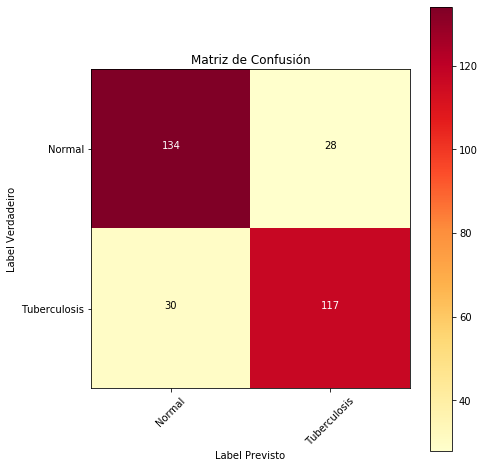

In [104]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf = confusion_matrix(y_test, y_pred_nnc)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [105]:
report = classification_report(y_test, y_pred_nnc , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.82      0.83      0.82       162
Tuberculosis       0.81      0.80      0.80       147

    accuracy                           0.81       309
   macro avg       0.81      0.81      0.81       309
weighted avg       0.81      0.81      0.81       309



**Matriz de Confusión Train**

Matriz de Confusão Sem Normalização
[[352   0]
 [  0 367]]


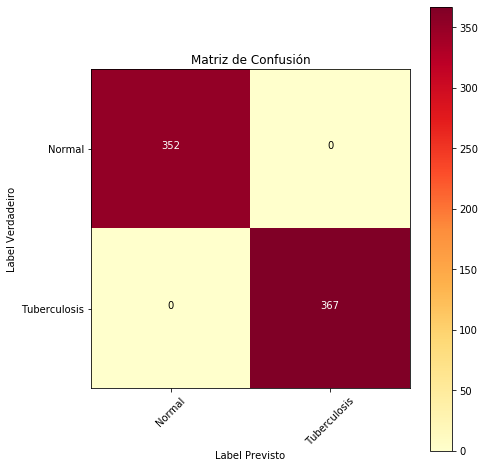

In [106]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf_rf = confusion_matrix(y_train, y_train_pred_rf)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf_rf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [107]:
report = classification_report(y_train, y_train_pred_nnc , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       352
Tuberculosis       1.00      1.00      1.00       367

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



**Gradient Boosting Classifier**

In [124]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=3.0, max_depth=10, random_state=50)
gbc.fit(X_train_tf, y_train)
# Previsiones 
y_train_pred_gbc = gbc.predict(X_train_tf)
y_pred_gbc = gbc.predict(X_test_tf)

print("Accuracy Test: %.5f"%metrics.accuracy_score(y_test, y_pred_gbc), '\n'
     'Accuracy Train: %.5f'%metrics.accuracy_score(y_train, y_train_pred_gbc))

Accuracy Test: 0.72816 
Accuracy Train: 1.00000


**Matriz Confusipn test

Matriz de Confusão Sem Normalização
[[112  38]
 [ 46 113]]


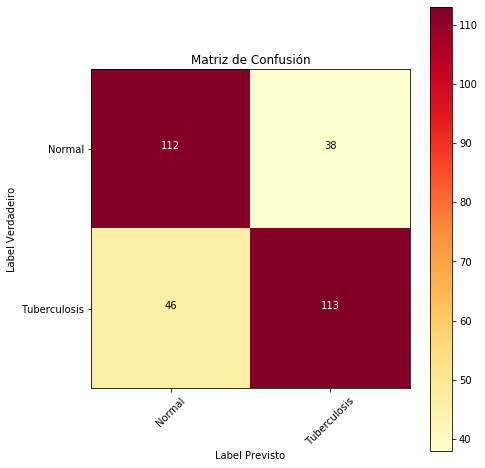

In [125]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf = confusion_matrix(y_test, y_pred_gbc)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [127]:
report = classification_report(y_test, y_pred_gbc , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       0.71      0.75      0.73       150
Tuberculosis       0.75      0.71      0.73       159

    accuracy                           0.73       309
   macro avg       0.73      0.73      0.73       309
weighted avg       0.73      0.73      0.73       309



**Matriz Confusión Train**

Matriz de Confusão Sem Normalização
[[364   0]
 [  0 355]]


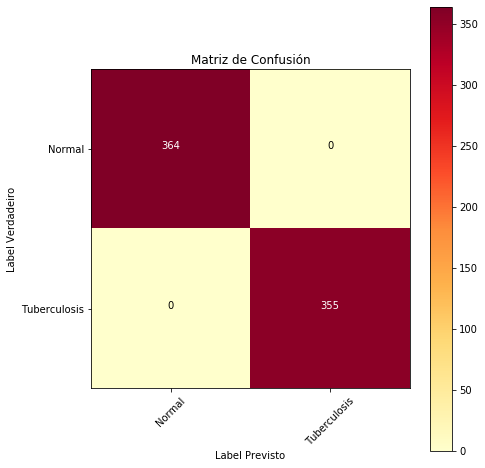

In [128]:
matriz_conf_plot_labels = ['Normal', 'Tuberculosis']
matriz_conf = confusion_matrix(y_train, y_train_pred_gbc)
plt.figure(figsize=(7,7))
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusión')

In [129]:
report = classification_report(y_train, y_train_pred_gbc , target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       364
Tuberculosis       1.00      1.00      1.00       355

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



Sería necesario hacer un estudio más exhaustivo para mejorar:
* La segmentación de las imágenes
* Para encontrar los mejores hiperparámetros de cada clasificador. 

# FIN